# Experiment to use Bayesian neural network to capture interation effects in logistic price-response model

This second notebook repeats the same structure as the first notebook, but takes a Bayesian approach in order to determine uncertainties in predictions and optimum prices.

## Preliminaries

In [1]:
import numpy as np
import pandas as pd
import random
import math
from numpy.random import default_rng
import math
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from scipy.optimize import minimize_scalar

In [2]:
%matplotlib inline

# Toy example to check can generate data and recover parameters correctly

## Generate dummy data to work with

In [3]:
data_params = {
    'intercept_A':1,
    'intercept_B':0,
    'price_slope_A':-1,
    'price_slope_B':-2,
    'pct_A':0.5,
    'noise_sd':1,
    'num_rows':10000,
    'price_min':1,
    'price_max':100
}

In [4]:
rng = default_rng()
is_A = rng.binomial(1, data_params['pct_A'], data_params['num_rows'])
is_B = 1 - is_A
real_price = rng.uniform(data_params['price_min'], data_params['price_max'], data_params['num_rows'])
price =  ( real_price - np.mean(real_price) ) / np.std(real_price)
price_A = is_A * price
price_B = is_B * price
noise = rng.normal(0, data_params['noise_sd'], data_params['num_rows'])
xB = is_A*data_params['intercept_A'] + is_B*data_params['intercept_B'] \
    + price_A*data_params['price_slope_A'] + price_B*data_params['price_slope_B'] + noise
probs = 1 / ( 1 + np.exp(-1*xB))
response = rng.binomial(1, probs)

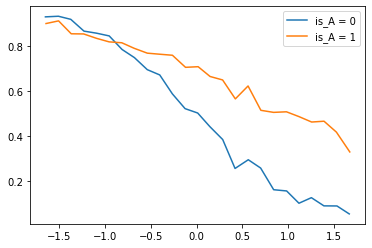

In [5]:
g = pd.DataFrame({'price':price.reshape(-1),'response':response, 'is_A':is_A}) 
g['price_cat'] = pd.cut(price.reshape(-1), 25)
gg = g.groupby(['price_cat','is_A']).mean().reset_index()
for i in gg['is_A'].unique():
    plt.plot('price','response', data=gg[gg['is_A']==i], label='is_A = ' + str(i))
plt.legend()    
plt.show()

In [6]:
a = np.column_stack((is_A, is_B, price, price_A, price_B, noise, xB, response))

In [7]:
df = pd.DataFrame(a, columns=['is_A', 'is_B', 'price', 'price_A', 'price_B', 'noise', 'xB', 'response'])

In [8]:
df.sample(3)

,is_A,is_B,price,price_A,price_B,noise,xB,response
7989,1.0,0.0,1.176863,1.176863,0.0,1.102712,0.925850,1.0
7143,1.0,0.0,0.338179,0.338179,0.0,-2.012172,-1.350351,0.0
5124,1.0,0.0,0.946493,0.946493,0.0,0.409840,0.463347,0.0


## Prep data for modelling

### Test / train split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('response',axis=1), df['response'], test_size=0.30, random_state=101)

### Create generator to yield batches for NN training

In [10]:
def get_batch(X, X_cols, y, batch_size=56):
    X = X[X_cols]
    l = len(X)
    i = 0
    while i + 1 < l:
        first = i
        last = min(first+batch_size, l)
        yield torch.tensor(X[first:last].values.astype(np.float32)), torch.tensor(y[first:last].values.astype(np.float32))
        i = last

## Bayesian model in Pyro using variational inference

In [11]:
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from torch.distributions import constraints
from pyro.nn import PyroModule, PyroParam, PyroSample
from pyro.nn.module import to_pyro_module_
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal
from pyro.optim import Adam

In [12]:
class BayesianMLP(PyroModule):
    def __init__(self, in_size=2, out_size=2):
        super().__init__()
        self.fc2_weight = PyroSample(prior=dist.Normal(0, 200).expand([in_size, out_size]).to_event(2))
        #true_mu = torch.tensor([[1., -1.],[0., -2.]])
        #small_sigma = torch.tensor([[0.01, 0.01], [0.01, 0.01]])
        #self.fc2_weight = PyroSample(prior=dist.Normal(true_mu, small_sigma).to_event(2))
    def forward(self, x):
        # assume price is in the last column of x...only use non-price columns in NN
        price = x[:,-1]
        x = x[:,:-1]                             
        #x = self.fc1_bias + torch.matmul(x, self.fc2_weight)  # this line samples bias and weight   
        x = torch.matmul(x, self.fc2_weight)  # this line samples bias and weight
        xB = x[:,0] + x[:,1]*price
        return xB

In [13]:
class Model(PyroModule):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.linear = BayesianMLP(in_size, out_size)

    def forward(self, x, y=None):
        logits = self.linear(x)
        noise_scale = pyro.sample("sigma_scale", dist.HalfNormal(scale=10))
        noise = torch.distributions.Normal(torch.zeros(1), noise_scale).sample([len(x)])
        probs = 1 / ( 1 + torch.exp(-logits))
        with pyro.plate("instances"):
            pyro.sample("obs", dist.Bernoulli(probs).to_event(1), obs=y)
        return probs

In [14]:

pyro.clear_param_store()
pyro.set_rng_seed(1)

model = Model(2, 2)
x = torch.tensor(X_train[['is_A', 'is_B', 'price']].values.astype(np.float32))

In [15]:
y = torch.tensor(y_train.values.astype(np.float32))
print(y.numel())
guide = AutoNormal(model)
svi = SVI(model, guide, Adam({"lr": 0.005}), Trace_ELBO())
for step in range(2500):
    loss = svi.step(x, y) / y.numel()
    if step % 100 == 0:
        print("step {} loss = {:0.4g}".format(step, loss))

7000
step 0 loss = 0.7128
step 100 loss = 0.6151
step 200 loss = 0.5616
step 300 loss = 0.5457
step 400 loss = 0.5371
step 500 loss = 0.533
step 600 loss = 0.5314
step 700 loss = 0.5311
step 800 loss = 0.5319
step 900 loss = 0.531
step 1000 loss = 0.5309
step 1100 loss = 0.5311
step 1200 loss = 0.5313
step 1300 loss = 0.5312
step 1400 loss = 0.5308
step 1500 loss = 0.531
step 1600 loss = 0.5309
step 1700 loss = 0.531
step 1800 loss = 0.5311
step 1900 loss = 0.531
step 2000 loss = 0.5309
step 2100 loss = 0.531
step 2200 loss = 0.5309
step 2300 loss = 0.531
step 2400 loss = 0.5309


In [16]:
with poutine.trace() as tr:
    model(x)
for site in tr.trace.nodes.values():
    print(site["type"], site["name"], site["value"].shape)

sample linear.fc2_weight torch.Size([2, 2])
sample sigma_scale torch.Size([])
sample obs torch.Size([7000])


In [17]:
with poutine.trace() as tr:
    guide(x)
for site in tr.trace.nodes.values():
    print(site["type"], site["name"], site["value"].shape)

param AutoNormal.locs.linear.fc2_weight torch.Size([2, 2])
param AutoNormal.scales.linear.fc2_weight torch.Size([2, 2])
sample linear.fc2_weight_unconstrained torch.Size([2, 2])
sample linear.fc2_weight torch.Size([2, 2])
param AutoNormal.locs.sigma_scale torch.Size([])
param AutoNormal.scales.sigma_scale torch.Size([])
sample sigma_scale_unconstrained torch.Size([])
sample sigma_scale torch.Size([])


In [18]:
for name in pyro.get_param_store().get_all_param_names():
    #print("[%s]: %.3f" % (name, pyro.param(name).data.numpy()))
    print("[%s]: %s" % (name, pyro.param(name).data.numpy()))

[AutoNormal.locs.linear.fc2_weight]: [[ 0.8033078  -0.7585894 ]
 [-0.01818926 -1.6697407 ]]
[AutoNormal.scales.linear.fc2_weight]: [[0.04035193 0.04092488]
 [0.0412463  0.06218879]]
[AutoNormal.locs.sigma_scale]: 1.7888602
[AutoNormal.scales.sigma_scale]: 0.72214305


In [19]:
from pyro.infer import Predictive
xt = torch.tensor(X_test[['is_A', 'is_B', 'price']].values.astype(np.float32))
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("linear.fc2_weight", "sigma_scale", "obs", "_RETURN"))
samples = predictive(xt)

In [20]:
postdist_samples = samples['obs'].squeeze().T.numpy()
yhat_samples = samples['_RETURN'].squeeze().T.numpy()

In [21]:
g = pd.concat( [ X_test.reset_index(drop=True), y_test.reset_index(drop=True),
                pd.DataFrame({ 'postdist_samples':list(postdist_samples), 'yhat_samples':list(yhat_samples) }) ], axis=1)

In [22]:
def ptile(s):
    l = tuple( s[i] for i in s.index )
    c = np.vstack(l)
    m = np.mean(c, axis=0)
    return list(np.percentile(m, [5., 95.])) + [np.mean(c)]

In [23]:
g['price_cat'] = pd.cut(g.price, 10)
gg = g.groupby(['price_cat','is_A'])[['price', 'response', 'postdist_samples', 'yhat_samples']].agg({'price':'mean', 'response':'mean', 'postdist_samples':ptile, 'yhat_samples':ptile }).reset_index()

In [24]:
gg['postdist_5pct'] = gg['postdist_samples'].apply(lambda x: x[0])
gg['postdist_95pct'] = gg['postdist_samples'].apply(lambda x: x[1])
gg['yhat_5pct'] = gg['yhat_samples'].apply(lambda x: x[0])
gg['yhat_95pct'] = gg['yhat_samples'].apply(lambda x: x[1])
gg['postdist_mean'] = gg['postdist_samples'].apply(lambda x: x[2])
gg['yhat_mean'] = gg['yhat_samples'].apply(lambda x: x[2])
gg.drop(columns=['postdist_samples', 'yhat_samples'], inplace=True)

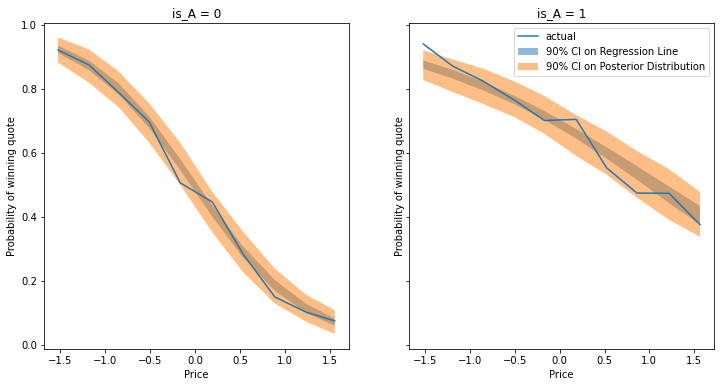

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
for i in gg['is_A'].unique().astype(int):
    ax[i].plot('price','response', data=gg[gg['is_A']==i], label='actual')
    ax[i].fill_between('price', 'yhat_5pct', 'yhat_95pct', data=gg[gg['is_A']==i], label='90% CI on Regression Line', alpha=0.5)
    ax[i].fill_between('price', 'postdist_5pct', 'postdist_95pct', data=gg[gg['is_A']==i], label='90% CI on Posterior Distribution', alpha=0.5)
    ax[i].set_xlabel('Price')
    ax[i].set_ylabel('Probability of winning quote')
    ax[i].set_title('is_A = ' + str(i))
plt.legend()
plt.show()

### MCMC instead of VI

In [26]:
from pyro.infer import MCMC, NUTS
num_samples=1000
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples, warmup_steps=200)
mcmc.run(x,y)
samples = mcmc.get_samples()
predictive=Predictive(model, samples, return_sites=("linear.fc2_weight", "sigma_scale", "obs", "_RETURN"))(xt, None)
print(mcmc.summary())

Sample: 100%|████████████████████████████████████| 1200/1200 [00:25, 46.87it/s, step size=6.70e-01, acc. prob=0.754]



                            mean       std    median      5.0%     95.0%     n_eff     r_hat
linear.fc2_weight[0,0]      0.79      0.04      0.79      0.73      0.86    864.22      1.00
linear.fc2_weight[0,1]     -0.76      0.04     -0.76     -0.83     -0.69    856.45      1.00
linear.fc2_weight[1,0]     -0.02      0.04     -0.02     -0.08      0.05    805.85      1.00
linear.fc2_weight[1,1]     -1.67      0.05     -1.67     -1.76     -1.58    797.64      1.00
           sigma_scale      7.54      5.90      6.48      0.01     16.26    844.45      1.00

Number of divergences: 2
None


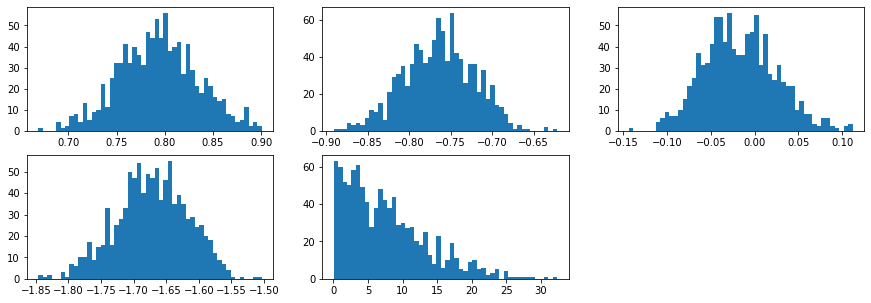

In [27]:
fc2_weight_samples = samples['linear.fc2_weight'].view(num_samples, -1)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))
ax = ax.flatten()
for w in range(fc2_weight_samples.size(1)):
    ax[w].hist(fc2_weight_samples[:,w].numpy(), bins=50)
ax[4].hist(samples['sigma_scale'].numpy(), bins=50)
ax[5].axis('off')
plt.show()

In [28]:
postdist_samples = predictive['obs'].squeeze().T.numpy()
yhat_samples = predictive['_RETURN'].squeeze().T.numpy()

In [29]:
g = pd.concat( [ X_test.reset_index(drop=True), y_test.reset_index(drop=True),
                pd.DataFrame({ 'postdist_samples':list(postdist_samples), 'yhat_samples':list(yhat_samples) }) ], axis=1)
g['price_cat'] = pd.cut(g.price, 10)
gg = g.groupby(['price_cat','is_A'])[['price', 'response', 'postdist_samples', 'yhat_samples']].agg({'price':'mean', 'response':'mean', 'postdist_samples':ptile, 'yhat_samples':ptile }).reset_index()

In [30]:
gg['postdist_5pct'] = gg['postdist_samples'].apply(lambda x: x[0])
gg['postdist_95pct'] = gg['postdist_samples'].apply(lambda x: x[1])
gg['yhat_5pct'] = gg['yhat_samples'].apply(lambda x: x[0])
gg['yhat_95pct'] = gg['yhat_samples'].apply(lambda x: x[1])
gg['postdist_mean'] = gg['postdist_samples'].apply(lambda x: x[2])
gg['yhat_mean'] = gg['yhat_samples'].apply(lambda x: x[2])
gg.drop(columns=['postdist_samples', 'yhat_samples'], inplace=True)

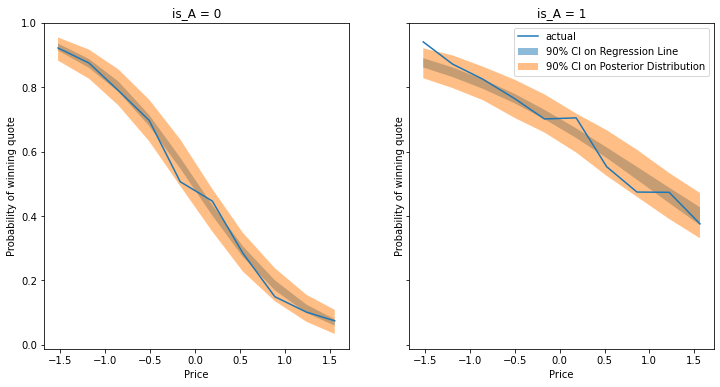

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
for i in gg['is_A'].unique().astype(int):
    ax[i].plot('price','response', data=gg[gg['is_A']==i], label='actual')
    ax[i].fill_between('price', 'yhat_5pct', 'yhat_95pct', data=gg[gg['is_A']==i], label='90% CI on Regression Line', alpha=0.5)
    ax[i].fill_between('price', 'postdist_5pct', 'postdist_95pct', data=gg[gg['is_A']==i], label='90% CI on Posterior Distribution', alpha=0.5)
    ax[i].set_xlabel('Price')
    ax[i].set_ylabel('Probability of winning quote')
    ax[i].set_title('is_A = ' + str(i))
plt.legend()
plt.show()

###  Check MCMC parameter estimates vs those from logistic model

In [32]:
reg = LogisticRegression(fit_intercept=False)
x_cols = ['is_A', 'is_B', 'price_A', 'price_B']
reg.fit(X_train[x_cols], y_train)
est_B = reg.coef_.reshape(-1)
print(est_B)

[ 0.79233381 -0.01574035 -0.76219153 -1.66512244]


Perfect match, phew!

# More complex example

## Generate dummy data to work with

In [33]:
data_params = {
    'num_features': 10,
    'features_mean':0,
    'features_std':1,
    'main_effect_mean':2,
    'main_effect_std':1,
    'price_slope':-3,
    'price_effect_max':-0.1,
    'price_effect_min':-2,
    'num_interactions': 5,
    'num_price_interactions':5,
    'interaction_effect_mean':0,
    'interaction_effect_std':1,   
    'price_interaction_effect_max':-0.1,
    'price_interaction_effect_min':-0.5,    
 
    'noise_sd':0.1,
    'num_rows':10000,
    'price_min':10,
    'price_max':100
}

In [34]:
rng = default_rng()

x_1 = rng.normal(data_params['features_mean'], data_params['features_std'], (data_params['num_rows'], data_params['num_features']))
B_1 = rng.normal(data_params['main_effect_mean']/data_params['num_features'], data_params['main_effect_std']/data_params['num_features'], data_params['num_features'])

real_price = rng.uniform(data_params['price_min'], data_params['price_max'], data_params['num_rows'])
price =  real_price / data_params['price_max']
price = price.reshape(-1,1)

B_price = np.array([data_params['price_slope']])

x_1p = x_1 * price
B_1p = rng.uniform(data_params['price_effect_min']/data_params['num_features'], data_params['price_effect_max']/data_params['num_features'], data_params['num_features'])

feature_pairs = []
for i in range(data_params['num_features']):
    for j in range(data_params['num_features']):
        if i != j:
            feature_pairs.append((i,j))

interactions = random.sample(feature_pairs, data_params['num_interactions'])
price_interactions = random.sample(feature_pairs, data_params['num_price_interactions'])

x_2 = np.empty(shape=(data_params['num_rows'], data_params['num_interactions']))
for i, pair in enumerate(interactions):
    x_2[:,i] = x_1[:,pair[0]] * x_1[:,pair[1]]
x_2p = x_2 * price

B_2 = rng.normal(data_params['interaction_effect_mean'], data_params['interaction_effect_std'], data_params['num_interactions'])
B_2p = rng.uniform(data_params['price_interaction_effect_min']/data_params['num_price_interactions'], data_params['price_interaction_effect_max']/data_params['num_price_interactions'], data_params['num_price_interactions'])

x = np.column_stack((x_1, price, x_1p, x_2, x_2p))
B = np.concatenate((B_1, B_price, B_1p, B_2, B_2p))
xB = np.dot(x, B)

noise = rng.normal(0, data_params['noise_sd'], data_params['num_rows'])

probs = 1 / ( 1 + np.exp(-1*(xB + noise)))
response = rng.binomial(1, probs)

alpha = np.dot( np.column_stack((x_1, x_2)), np.concatenate((B_1, B_2)) )
beta = (xB - alpha) / price.reshape(-1)

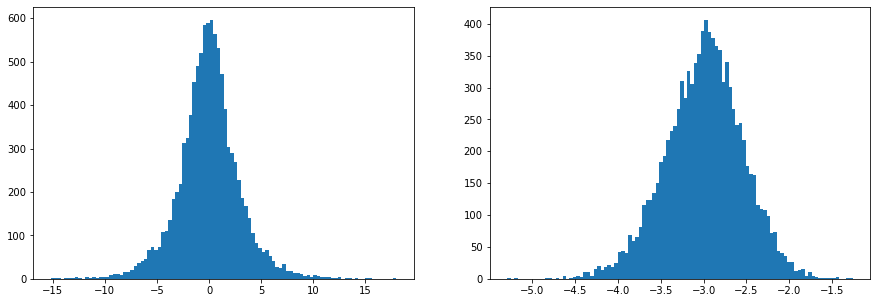

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
_ = ax1.hist(alpha, bins=100)
_ = ax2.hist(beta, bins=100)

In [36]:
def grid_plot(alpha, beta, rows=8, columns=6):
    
    idx = random.sample(range(len(alpha)),rows*columns)
    price = np.arange(0,1,0.05)
    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15,10), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        logit = alpha[i] + price*beta[i]
        response = 1 / ( 1 + np.exp(-1*logit))
        ax.plot(price, response)

    plt.show()

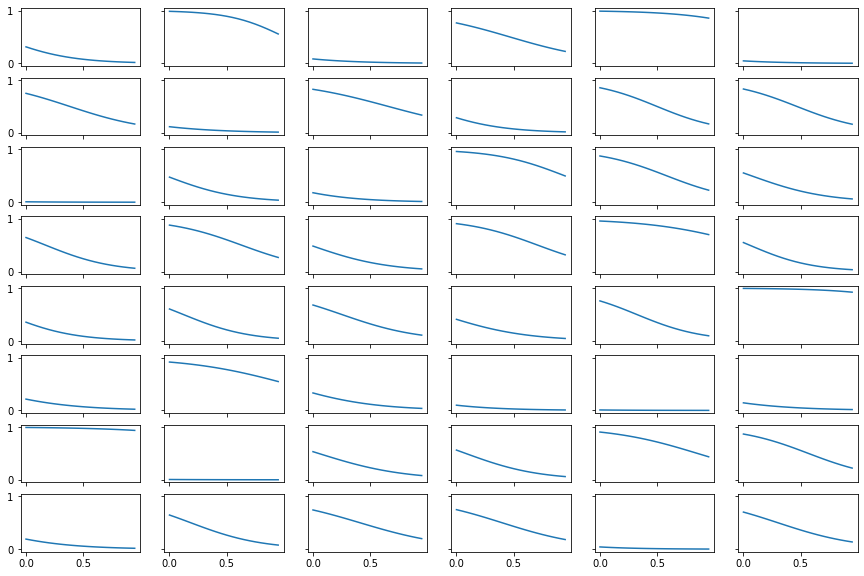

In [37]:
grid_plot(alpha, beta)

In [38]:
a = np.column_stack((x_1, price, x_1p, x_2, x_2p, alpha, beta, response))
b = a[beta<0]

In [39]:
x_cols = [ "x_" + str(i+1) for i in range(data_params['num_features']) ]
xp_cols = [ "xp_" + str(i+1) for i in range(data_params['num_features']) ]
i_cols = [ "x_" + str(pair[0]+1) + "_" + str(pair[1]+1) for pair in interactions ]
ip_cols = [ i + "_p" for i in i_cols ]

In [40]:
df = pd.DataFrame(b, columns=x_cols + ['price'] + xp_cols + i_cols + ip_cols + ['alpha', 'beta', 'response'])

In [41]:
df.sample(3)

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_4_7,x_2_8,x_2_10_p,x_9_1_p,x_1_10_p,x_4_7_p,x_2_8_p,alpha,beta,response
9953,0.746693,-1.231967,2.192542,-0.881381,-0.532342,-0.554097,-1.636858,1.067330,-0.938754,2.913944,...,1.442696,-1.314916,-3.460776,-0.675751,2.097569,1.390810,-1.267626,1.705240,-2.821523,1.0
3850,-0.372241,2.243864,0.314705,-0.395889,-0.229960,0.548145,1.013641,0.143207,0.249063,0.625538,...,-0.401290,0.321337,1.298576,-0.085773,-0.215425,-0.371257,0.297289,-0.323242,-3.491788,0.0
4962,-0.783811,0.963317,0.596036,0.359117,-0.199791,0.884597,0.146905,0.538286,-0.903124,0.708813,...,0.052756,0.518540,0.439708,0.455851,-0.357772,0.033973,0.333923,2.065478,-3.372590,0.0


## Prep data for modelling

### Test train split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('response',axis=1), df['response'], test_size=0.30, random_state=101)

### Generator to yield batches of data for NN training

In [43]:
def get_batch(X, X_cols, y, batch_size=56):
    X = X[X_cols]
    l = len(X)
    i = 0
    while i + 1 < l:
        first = i
        last = min(first+batch_size, l)
        yield torch.tensor(X[first:last].values.astype(np.float32)), torch.tensor(y[first:last].values.astype(np.float32))
        i = last

## NN model to predict response

#### Same simple MLP archtecture as first notebook, but now Bayesian

In [88]:
class BayesianMLP(PyroModule):
    def __init__(self, num_features, hidden_size):
        super().__init__()

        self.fc1_weight = PyroSample(prior=dist.Normal(0, 2).expand([num_features, hidden_size]).to_event(2))
        self.fc1_bias = PyroSample(prior=dist.Normal(0, 2).expand([hidden_size]).to_event(1))
        self.fc2_weight = PyroSample(prior=dist.Normal(0, 10).expand([hidden_size, 2]).to_event(2))
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        
        if x.dim == 1:
            x = torch.unsqueeze(x,0)
        
        # assume price is in the last column of x...only use non-price columns in NN
        price = x[:,-1]
        x = x[:,:-1]
        
        # pass x through fully connected layers, no activation, dropout, normalisation etc. for now....
        x = self.fc1_bias + torch.matmul(x, self.fc1_weight)
        x = self.tanh(x)
        x = torch.matmul(x, self.fc2_weight)
        
        # calculate
        alpha = x[:,0] 
        beta = x[:,1]
        xB = alpha + beta*price
        
        return xB, alpha, beta

In [89]:
class Model(PyroModule):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.linear = BayesianMLP(in_size, out_size)

    def forward(self, x, y=None):
        logits, alpha, beta = self.linear(x)
        #noise_scale = pyro.sample("sigma_scale", dist.HalfNormal(scale=10))
        #noise = torch.distributions.Normal(torch.zeros(1), noise_scale).sample([len(x)])
        probs = 1 / ( 1 + torch.exp(-logits))
        with pyro.plate("instances"):
            pyro.sample("obs", dist.Bernoulli(probs).to_event(1), obs=y)
        return torch.stack([probs, alpha, beta])

In [90]:
num_features = len(x_cols)
#model = Model(num_features, int(num_features/2))
model = Model(num_features, num_features)

In [91]:
x = torch.tensor(X_train[x_cols+['price']].values.astype(np.float32))
y = torch.tensor(y_train.values.astype(np.float32))

#### Using variational inference (commented now as MCMC gives significantly better results)

In [92]:
# guide = AutoNormal(model)

# pyro.clear_param_store()
# pyro.set_rng_seed(1)

# num_iterations = 5000
# initial_lr = 0.01
# gamma = 0.1  # final learning rate will be gamma * initial_lr
# lrd = gamma ** (1 / num_iterations)
# optimizer = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas':(0.95, 0.999)})

# svi = SVI(model, 
#           guide, 
#           optimizer, 
#           loss=Trace_ELBO())

In [93]:
# losses = []
# for i in range(num_iterations):
#     loss = svi.step(x, y) / y.numel()
#     losses.append(loss)
#     if i % 100 == 0:
#             print("[iteration %04d] loss: %.4f" % (i + 1, loss))

In [94]:
#predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=("obs", '_RETURN'))

In [95]:
# for name in pyro.get_param_store().get_all_param_names():
#     print(name, pyro.param(name).data)

####  MCMC rather than VI...(understandably) slow so commented-out for now

In [96]:
from pyro.infer import MCMC, NUTS
num_samples=400
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples, warmup_steps=100, num_chains=1)
mcmc.run(x,y)
samples = mcmc.get_samples()
xt = torch.tensor(X_test[x_cols+['price']].values.astype(np.float32))
predictive=Predictive(model, samples, return_sites=("linear.fc2_weight", "sigma_scale", "obs", "_RETURN"))
print(mcmc.summary())

Sample: 100%|██████████████████████████████████████| 500/500 [47:14,  5.67s/it, step size=3.48e-03, acc. prob=0.893]


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
    linear.fc1_bias[0]      4.03      1.45      4.19      1.21      5.82     12.56      1.11
    linear.fc1_bias[1]     -0.95      0.11     -0.95     -1.10     -0.76     85.21      1.07
    linear.fc1_bias[2]      0.05      1.79      0.47     -2.58      3.13     30.50      1.02
    linear.fc1_bias[3]     -0.60      1.64     -0.80     -2.85      2.66     25.33      1.07
    linear.fc1_bias[4]     -0.92      0.08     -0.92     -1.03     -0.77    268.12      1.00
    linear.fc1_bias[5]     -1.00      0.09     -0.99     -1.16     -0.86    102.83      1.00
    linear.fc1_bias[6]      1.18      0.29      1.11      0.85      1.59     28.62      1.00
    linear.fc1_bias[7]     -1.24      0.17     -1.23     -1.53     -1.00     47.49      1.06
    linear.fc1_bias[8]      0.89      0.10      0.88      0.73      1.06     37.68      1.13
    linear.fc1_bias[9]      1.12      0.10      1.12      0.95      1

#### Test to see whether mini-batch training would help...it didn't

In [53]:
# optimizer = Adam({"lr": 0.001})

# losses = []
# for i in range(num_iterations):
#     iter_loss = 0.
#     iter_row_count = 0.
#     for x, y in get_batch(X_train, x_cols+['price'], y_train, batch_size=1024):
#         batch_loss = svi.step(x, y) 
#         iter_loss += batch_loss
#         iter_row_count += y.numel()
        
#     losses.append(iter_loss/iter_row_count)
#     if i % 100 == 0:
#         print("[iteration %04d] loss: %.4f" % (i + 1, losses[i]))

In [97]:
#xt = torch.tensor(X_test[x_cols+['price']].values.astype(np.float32))
yt = torch.tensor(y_test.values.astype(np.float32))

In [98]:
def get_bid_response_samples(xn, price_points):
    num_price_points = len(price_points)
    num_cols = xn.shape[1]
    num_examples = xn.size(0)

    xn = xn[:,:-1] # drop actual actual price column
    xp = np.empty((num_examples,num_price_points,num_cols))

    for i in range(num_examples):
        xi = xn[i]
        xii = np.tile(xi,(num_price_points,1))
        pp = price_points.reshape(num_price_points,1)
        xp[i] = np.hstack((xii,pp))

    return predictive(torch.tensor(xp.reshape(-1,num_cols).astype(np.float32)), None)

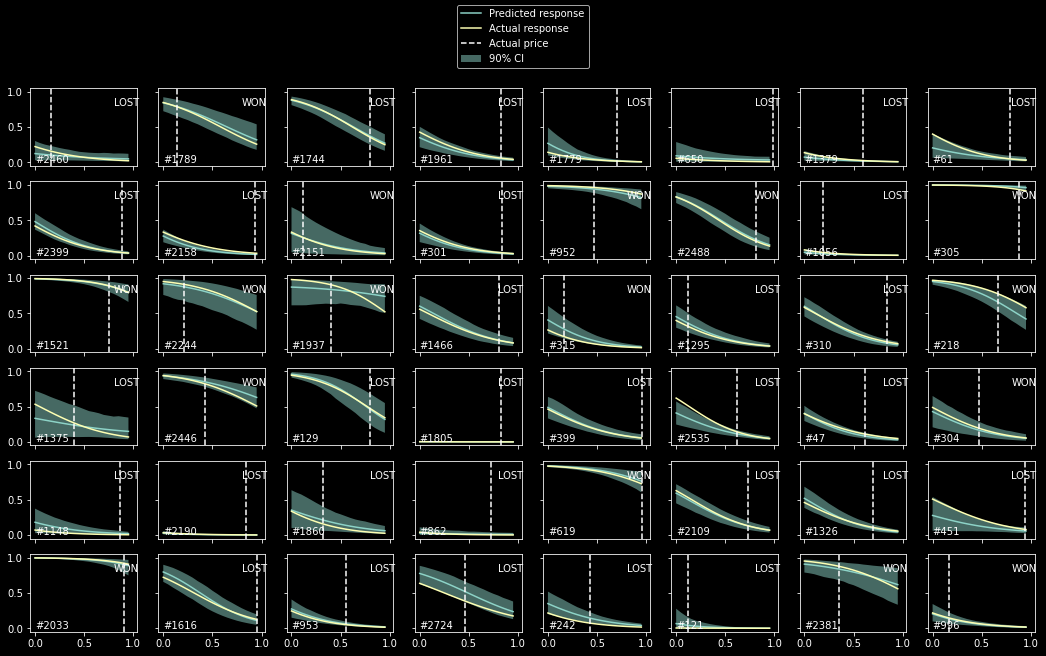

In [99]:
rows = 6
columns = 8
examples = rows*columns
min_price = 0
max_price = 1
price_step = 0.05
price_points = np.arange(min_price,max_price,price_step)
num_price_points = len(price_points)

# select random row from data
rng = np.random.default_rng()
examples_idx = rng.choice(np.arange(xt.shape[0]), examples, replace=False)
xn = xt[examples_idx]

# sample posterior distribution at price points
bid_response_samples = get_bid_response_samples(xn, price_points)
reg_samples = bid_response_samples['_RETURN']
dist_samples = bid_response_samples['obs']

# grab a and b to plot actual response curve
ab = torch.tensor(X_test[['alpha', 'beta']].values.astype(np.float32))
abn = ab[examples_idx]

plt.style.use('dark_background')
fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(18,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    reg_sample = reg_samples[:,0,i*num_price_points:(i+1)*num_price_points].numpy()
    price = price_points
    response_mean = np.mean(reg_sample,axis=0)
    response_ptiles = list(np.percentile(reg_sample, [5., 95.], axis=0))
    response_5pct = response_ptiles[0]
    response_95pct = response_ptiles[1]
    actual_response = 1 / (1 + np.exp(-1*(abn[i,0] + abn[i,1]*price_points )))
    ax.plot(price, response_mean, label='Predicted response')
    ax.fill_between(price, response_5pct, response_95pct, label='90% CI', alpha=0.5)
    ax.plot(price, actual_response, label='Actual response')
    ax.axvline(xn[i,-1], linestyle='--', label='Actual price')
    textstr = 'WON' if yt[examples_idx[i]] == 1. else 'LOST'
    ax.text(0.8, 0.8, textstr)
    ax.text(0, 0, '#' + str(examples_idx[i]))
    
handles = plt.gca().get_lines()
fig.legend(labels=['Predicted response','Actual response','Actual price','90% CI'], loc='upper center')    
plt.show()

## Assess model performance vs naive and 'perfect' logistic regression models

### A logistic regression model with the same structure as the logistic equation used to generate the data can accurately recover the parameter values used in that equation

In [106]:
complete_reg = LogisticRegression()
complete_reg.fit(X_train[x_cols + ['price'] + xp_cols + i_cols + ip_cols], y_train)

LogisticRegression()

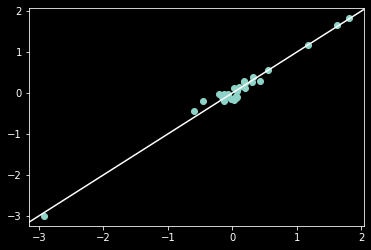

In [107]:
est_B = complete_reg.coef_.reshape(-1) # parameter values estimated by complete model
actual_B = np.concatenate((B_1, B_price, B_1p, B_2, B_2p)) # parameter values used to generate data

plt.scatter(est_B, actual_B)
plt.axline([0, 0], [1, 1])

In [108]:
complete_pred = complete_reg.predict_proba(X_test[x_cols + ['price'] + xp_cols + i_cols + ip_cols])[:,1]
complete_loss = log_loss(y_test, complete_pred)
print('The average loss on the test data for the "complete" logistic regression model is: ' + '{:.2f}'.format(complete_loss))

The average loss on the test data for the "complete" logistic regression model is: 0.34


### A naive logistic regression model with only main effects has a signifcantly higher loss

In [109]:
simple_reg = LogisticRegression()
simple_reg.fit(X_train[x_cols+['price']], y_train)
simple_pred = simple_reg.predict_proba(X_test[x_cols+['price']])[:,1]
simple_loss = log_loss(y_test, simple_pred)
print('The average loss on the test data for the "naive" logistic regression model is: ' + '{:.2f}'.format(simple_loss))

The average loss on the test data for the "naive" logistic regression model is: 0.58


### The performace of the NN model can be benchmarked to these regression models

In [110]:
nn_samples = predictive(xt, None)
nn_pred = nn_samples['obs'].squeeze().double().mean(axis=0).numpy()
nn_loss = log_loss(y_test, nn_pred)
print('The average loss on the test data for the neural network model is: ' + '{:.2f}'.format(nn_loss))

The average loss on the test data for the neural network model is: 0.35


In [111]:
NN_performance = ( nn_loss - simple_loss ) / ( complete_loss - simple_loss )
print('The NN model achieves ' + '{:.0%}'.format(NN_performance) + ' of the performance of the "complete" model')

The NN model achieves 96% of the performance of the "complete" model


## Obtaining a confidence interval for the optimum price for a quote

To re-cap, the expected revenue from an individual quote depends on the profit earned if the quote is won and the probability that the quote will be won:

$E(\pi) = (p-c)y$

where $E(\pi)$ is the expected profit and $c$ is the incremental cost incurred if the quote is won.  This function has a unique maximum at price $p^*$, the optimum price

In [112]:
def expected_profit(price, cost=0, alpha=1, beta=-2, negative=False):
    return (-1 if negative else 1) * (price - cost) / ( 1 + math.exp(-1*(alpha + price*beta)))

In [113]:
row = 2371 # Index of row in test data that we want to plot
cost = 0.2

bid_response_samples = get_bid_response_samples(xt[row].unsqueeze(0), price_points)
reg_sample = bid_response_samples['_RETURN'][:,0,:].squeeze().numpy()
ab_sample = bid_response_samples['_RETURN'][:,1:,0].squeeze().numpy()

In [114]:
def wrap_minimise_scalar(s):
    alpha = s[0].item()
    beta = s[1].item()
    return minimize_scalar(expected_profit, bounds = (0,1), args=(cost, alpha, beta, True), method='Bounded').x

p_star_samples = np.apply_along_axis(wrap_minimise_scalar, 1, ab_sample)

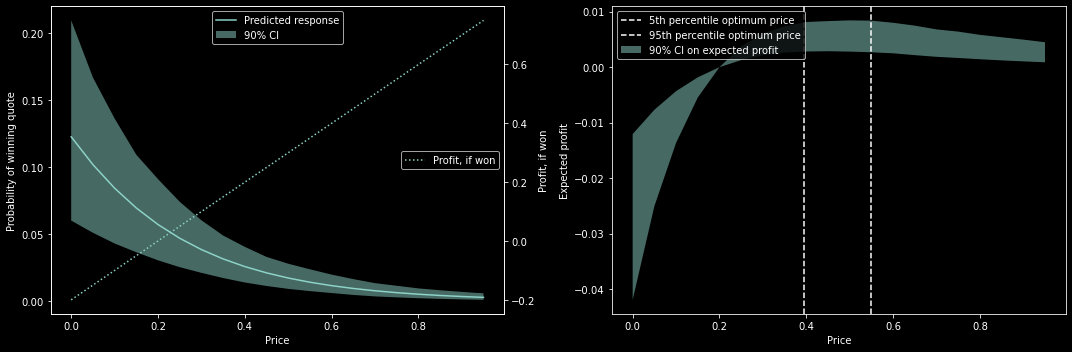

In [115]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Left hand plot, which is bid response
response_mean = np.mean(reg_sample,axis=0)
response_ptiles = np.percentile(reg_sample, [5., 95.], axis=0)
response_5pct = response_ptiles[0]
response_95pct = response_ptiles[1]
ax1.plot(price_points, response_mean, label='Predicted response')
ax1.fill_between(price_points, response_5pct, response_95pct, label='90% CI', alpha=0.5)
ax1.set_xlabel('Price')
ax1.set_ylabel('Probability of winning quote')
ax1.legend(loc='upper center')

ax11 = ax1.twinx()
pi = [ price - cost for price in price_points ]
ax11.plot(price_points, pi, label='Profit, if won', linestyle=':')
ax11.set_ylabel('Profit, if won')
ax11.legend(loc='right')

# Right hand plot, which is expected profit and optimum prices
ep_samples = (price_points - cost) * reg_sample
ep_CI = np.percentile(ep_samples, [5., 95.], axis=0)
ax2.fill_between(price_points, ep_CI[0], ep_CI[1], label='90% CI on expected profit', alpha=0.5)

p_star_CI = np.percentile(p_star_samples, [5., 95.])
ax2.axvline(p_star_CI[0], linestyle='--', label='5th percentile optimum price')
ax2.axvline(p_star_CI[1], linestyle='--', label='95th percentile optimum price')
ax2.set_xlabel('Price')
ax2.set_ylabel('Expected profit')
ax2.legend(loc='upper left')

plt.tight_layout()

As a bit of fun, test whether the 5th and 95th percenties of optimum price correspond to the optimum prices of the 5th and 95th percentile of predicted response

In [116]:
# regression line for the 5th and 95th perentiles of predicetd response
y = response_ptiles.T
y = np.log(y/(1-y))
A = np.vstack([price_points, np.ones(len(price_points))]).T
b, a = np.linalg.lstsq(A, y, rcond=None)[0]
print(b,a)

[-4.2357231  -3.92072479] [-2.61627876 -1.50470802]


0.43877674879438366
0.4642312223102997


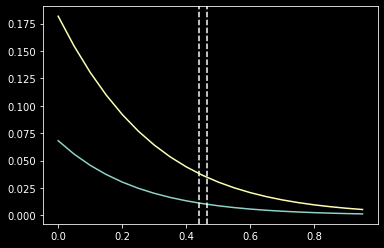

In [117]:
# plot these and the corresponding optimium prices
for i in range(len(a)):
    y_pred = 1 / ( 1 + np.exp(-1*(a[i] + b[i]*price_points)))
    p_star = minimize_scalar(expected_profit, bounds = (0,1), args=(cost, a[i], b[i], True), method='Bounded').x
    print(p_star)
    plt.plot(price_points, y_pred)
    plt.axvline(p_star, linestyle='--')